In [1]:
from gensim import corpora, models
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import re

In [11]:
path1 = os.listdir('./longdata')
path2 = os.listdir('./sumdata')[1:]
path2 = sorted(path2, key = lambda x : int(x.split('_')[0]))

In [60]:
def readdata(data, stopword, long):
    tt = ''
    if long == 'long':
        try:
            with open('./longdata/' + data,'r') as t921:
                for l in t921:
                    if l != '' :
                        tt += l
        except:
            with open('./longdata/' + data,'r', encoding = 'utf-8') as t921:
                for l in t921:
                    if l != '' :
                        tt += l            
    elif long == 'short':    
        with open('./sumdata/' + data,'r', encoding= 'UTF-8') as t921:
            for l in t921:
                if l != '' :
                    tt += l            
    for c in stopword:
        tt = tt.replace(c,'')
    tt = tt.replace('消費者物價指數','CPI')
    tt = tt.replace('CPICPI','CPI')
    tt = tt.replace('製造業採購經理人指數','PMI')
    tt = tt.replace('製造業經理人指數','NMI')
    #tt = tt.split('，')
    tt = re.split(r'[。；]', tt)
    return tt[:-1]            

In [61]:
stopword = ['\n','\r','\t','\u3000','：',' ','、','）','(','（',')','.','亦','在','將','至',
            '的','但','卻','及','為','且','呈','以','則','與','若','仍','惟','之','」','「','<','-',
           'http//wwwcbcgovtw>98','，']
stopword2 = ['\n','\r','\t','\u3000']
documents1 = []
documents2 = []
for i in path1:
    documents1 += readdata(i, stopword, long = 'long')
for i in path2:
    documents2 += readdata(i, stopword, long = 'short')
#先1分詞在2

In [62]:
print(f'會議記錄 : {len(documents1)}句')
print(f'新聞稿 : {len(documents2)}句')

會議記錄 : 1417句
新聞稿 : 2928句


In [63]:
word_to_weight = {'本年':1,'1月':1, '消費者物價指數':1, '金融市場恐慌指數':1,'金融情勢指數':1, 'EPU指數':1
                  , '擴張性財政政策':1,'實質薪資':1,'實質利率':1,'貿易保護主義':1,'脫歐':1,'隔夜拆款利率':1,
                 '上半年':1,'下半年':1,'全年':1,'年期':1, '擬案':1, '上年':1, '略升':1, '略緩':1, '較低':1,
                 '經濟成長':1,'貨幣政策':1,'預期通膨':1,'投資成長率':1,'稍緩':1,'經濟成長率':1,'物價上漲率':1
                 ,'貨幣成長':1,'蔬果價格':1,'原物料價格':1,'原物料價':0.5,'大宗':1,'本次':1,'經濟體':1}

In [64]:
import ckiptagger as ck                         #分詞套件
from ckiptagger import WS                       #分詞
ws = WS('./data')                               #載入分詞模型
word_to_weight = word_to_weight                  #自定義辭典
dictionre = ck.construct_dictionary(word_to_weight)
documents = documents1 + documents2 
ptt = ws(documents, recommend_dictionary = dictionre)  #將要分詞的文本丟入 recommend項 可以加入詞 EX:如果分的不好可以用
diction = corpora.Dictionary(ptt)               #將文本轉為辭典
diction.filter_extremes(no_below=3, no_above=0.5) #將在所有文本(此例為所有句子)中出現次數小於5 和大於50%的詞去掉
corpus = [diction.doc2bow(doc) for doc in ptt]   #將其轉為詞袋模型 EX:每個詞對上其出現的次數

In [65]:
print(f'共有{len(diction)}個詞彙')
print(f'共有{len(corpus)}段句子')
print(f'前{len(documents1)}句為會議記錄, 後{len(documents2)}句為新聞稿')

共有2454個詞彙
共有4345段句子
前1417句為會議記錄, 後2928句為新聞稿


In [124]:
def prioreta(x,n):                                       #建立 eta之prior
    p = np.ones(n)*0.5
    for i in x:
        p[diction.token2id[i]] = 0.9
 #   p = p/sum(p)    
    return p    
def record(dic,ind):                                    
    rec = []
    new_dict = {v : k for k, v in dic.token2id.items()}
    for c in ind:
        rec.append(new_dict[c])
    return rec    
def get_topic(x):                                         #將分類完後的句子提出機率最大的主題
    ind = []
    for i in range(len(x)):
        ind.append(max(model.get_document_topics(x[i]),key = lambda xx : xx[-1])[0])
    return ind    
def readdict(x):                                         
    path = x
    with open('./data/dictionary/' + path,'r', encoding = 'UTF-8') as ff:
        aa = []
        for l in ff:
            aa.append(l.replace('\n',''))
    return aa    
def senti(x, le, sepa, topic_index = None, adv = False):                  #統計正反面詞彙數量
    po = []
    ne = []
    po_tmp = []
    ne_tmp = []
    po_topic = []
    ne_topic = []
    nump = 0
    numn = 0
    if adv == False:
        for i in range(len(x)):
            for c in x[i]:
                if c in podict:
                    nump += 1
                if c in nedict:
                    numn += 1
            po.append(nump)
            ne.append(numn)
            nump = 0
            numn = 0              
    else:
        for c in x:
            try:
                if senti_dict2[c] == 0:
                    po.append(1)
                else:
                    po.append(0)
                if senti_dict2[c] == 1:
                    ne.append(1)
                else:
                    ne.append(0)
            except:
                po.append(0)
                ne.append(0)
                
    
    if sepa:
        po = [po[le[i]:le[i+1]] for i in range(len(le)-1)]
        ne = [ne[le[i]:le[i+1]] for i in range(len(le)-1)]
        for i in range(len(po)):
            for j in topic_index[i]:
                po_tmp.append(po[i][j])
                ne_tmp.append(ne[i][j])
            po_topic.append(sum(po_tmp))
            ne_topic.append(sum(ne_tmp))
            po_tmp = []
            ne_tmp = []
        return np.array([po_topic, ne_topic])    
    else:
        po = [sum(po[le[i]:le[i+1]]) for i in range(len(le)-1)]
        ne = [sum(ne[le[i]:le[i+1]]) for i in range(len(le)-1)]
        return np.array([po,ne]) 

def get_senti(cont):
    po = 0
    ne = 0
    for c in cont:
        if c in podict:
            po += 1
        elif c in nedict:
            ne += 1
    if po == 0 and ne != 0:
        return 'negative'
    elif po != 0 and ne == 0:
        return 'positive'
    elif po == 0 and ne == 0:
        return 'neutral'
    else:
        return 'unk'
def toneindex(sentinum):                                #計算tone指數
    toneind = [] 
    po = sentinum[0]
    po = np.array(po)
    ne = sentinum[1]
    ne = np.array(ne)

    for i in range(len(po)):
        if po[i] + ne[i] != 0:
            toneind.append(((po[i] - ne[i]) / (po[i] + ne[i]))*10)
        else:
            toneind.append(0)
    return toneind   
def toneindex2(sentinum,le):
    toneind = []
    po = sentinum[0]
    ne = sentinum[1]
    for i in range(len(po)):
        length = le[i+1] - le[i]
        toneind.append(10 * (po[i]-ne[i]) / length)
    return toneind
    
def sepa_topic(topics,le):                               #將各主題分開
   
    topic = []
    topic00 = []
    topic11 = []
    topic22 = []
    topic33 = []
    topic44 = []
    topic55 = []
    topic66 = []
#    topic77 = []
    topic_0 = []
    topic_1 = []
    topic_2 = []
    topic_3 = []
    topic_4 = []
    topic_5 = []
    topic_6 = []
#    topic_7 = []
    for i in range(len(le)-1):
        topic.append(topics[le[i]:le[i+1]])
    for i in range(len(topic)):
        for j in range(len(topic[i])):
            if topic[i][j] == 0:
                topic00.append(j)
            elif topic[i][j] == 1:
                topic11.append(j)
            elif topic[i][j] == 2:
                topic22.append(j)
            elif topic[i][j] == 3:
                topic33.append(j)
            elif topic[i][j] == 4:
                topic44.append(j)  
            elif topic[i][j] == 5:
                topic55.append(j)               
            else :
                topic66.append(j)                
        topic_0.append(topic00)
        topic_1.append(topic11)
        topic_2.append(topic22)
        topic_3.append(topic33)
        topic_4.append(topic44)
        topic_5.append(topic55)
        topic_6.append(topic66)
        topic00 = []
        topic11 = []
        topic22 = []
        topic33 = []
        topic44 = []
        topic55 = []
        topic66 = []
    return np.array([topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6])    
def topicnum(x):                                                #計算各主題數量
    ll = [len(x[i]) for i in range(len(x))]
    return ll
def find_word(x):
    where_word = []
    for i in ptt:
        if x in i:
            where_word.append(i)
    return where_word       
def plot_cycle():
    plt.axvspan(0,2,facecolor='0.25',alpha=0.25)
    plt.axvspan(8,23,facecolor = '0.25', alpha=0.25)
    plt.axvspan(25,38,facecolor = '0.25', alpha=0.25)
    plt.axvspan(45.5,53.5,facecolor = '0.25', alpha=0.25)
    plt.axvspan(57,64.5,facecolor = '0.25', alpha=0.25)
    plt.axvspan(73,88,facecolor = '0.25', alpha=0.25)
def get_topic2(x):                                         #將分類完後的句子提出機率最大的主題
    ind = []
    em = [3,4,7,8,10]
    price = [0,13,17,18,19]
    rate = [1,2,5,6,9,11,12,14,15,16]
    for i in range(len(x)):
        topic = max(model.get_document_topics(x[i]),key = lambda xx : xx[-1])[0]
        if topic in rate:
            ind.append(0)
        elif topic in price:
            ind.append(1)
        else:
            ind.append(2)
    return ind  

In [67]:
long_le =[0] + [len(readdata(i, stopword, long = 'long')) for i in path1]
long_le = [sum(long_le[0:i+1]) for i in range(len(long_le))]
short_le = [0] + [len(readdata(i, stopword, long = 'short')) for i in path2]
short_le = [sum(short_le[0:i+1]) for i in range(len(short_le))]
mix_le = [0] + [len(readdata(i, stopword, long = 'short')) for i in path2[:-10]] + [len(readdata(i, stopword, long = 'short')) + len(readdata(i, stopword, long = 'long')) for i in path2[-10:]]
mix_le = [sum(mix_le[0:i+1]) for i in range(len(mix_le))]
podict = readdict('Positive.valid.txt')                    #正負字典讀取
nedict = readdict('Negative.valid.txt')

In [68]:
train4 = pd.DataFrame()
train4['non_sentent'] = ptt
train4['sentent'] = documents1 + documents2
train4['labels'] = train4['non_sentent'].map(get_senti)
#train4[].to_csv('train4_neu.csv', index = None)

In [69]:
senti_dict = {'positive':0, 'negative':1, 'neutral':2, 'unk':2}
train4['labels'] = train4['labels'].map(senti_dict)
train4 = train4[train4['labels'] != 2].drop(['non_sentent'], axis=1)
print(train4.shape)
train4.head()

(1626, 2)


,sentent,labels
1,壹國內外經濟金融情勢1經濟研究處說明一國際經濟金融情勢隨全球製造業貿易活動漸趨活絡本年全球經...,0
2,多數經濟體展望趨於樂觀,0
6,近期國際股市普遍上揚金融市場恐慌指數VIX表現平穩,0
10,二國內經濟金融情勢一經濟情勢自本年3月本行理事會會議迄今隨國內景氣復甦就業人數增加失業率續降...,0
11,國內經濟雖穩定成長近月出口資本設備進口成長轉緩零售業營業額成長有限景氣對策信號轉黃藍燈,1


In [70]:
test_set = pd.read_csv('test_set.csv')
test_set = pd.concat([test_set, train4])
print(test_set.shape)
test_set = test_set.dropna(axis=0)
print('After dropna')
print(test_set.shape)

(4322, 2)
After dropna
(4287, 2)


In [71]:
test_set['labels'].value_counts()

1    2140
0    1886
2     261
Name: labels, dtype: int64

In [74]:
senti_dict2 = dict(list(zip(test_set['sentent'], test_set['labels'])))
senti_dict2['討論事項：國內外經濟金融情勢與本行貨幣政策，提請討論'] = 2

In [17]:
freq_word = np.zeros(len(diction))
for i in ptt:
    for j in i:
        if j in diction.token2id.keys():
            freq_word[diction.token2id[j]] += 1 
freq_word = [(i,j) for i,j in zip(diction.token2id.keys(),freq_word)]
freq_word = sorted(freq_word,key=lambda x : x[1],reverse=True)

In [18]:
rate = ['利率','放款','升息','重貼現率',
       '年息','實質利率','升值','股市','隔夜拆款利率','匯價','公債','殖利率']
employment = ['市場','景氣','經濟成長','經濟成長率','勞動','失業率','產出','就業','薪資','生產']
price = ['物價','通膨','CPI','消費','油價','消費者','原物料','進口','原油','蔬果','能源'
        ]
non = freq_word[:20]
uncertain = ['年增率','主計處','資產','資本','房貸','存款']

In [19]:
import numpy as np
employ = prioreta(employment, len(diction))
rates = prioreta(rate, len(diction))
prices = prioreta(price, len(diction))
#other = np.ones((2,len(diction)))
eta = np.array([employ, rates, prices])
#eta = np.vstack((eta,other))

In [114]:
from gensim.models import LdaModel
model = LdaModel(corpus = corpus, id2word = diction, chunksize =4500 ,  alpha='auto'#, eta = eta
                 , iterations = 10000, num_topics = 7, passes = 25, eval_every = None
                )

In [115]:
#model.save('./model/LDA_model_5topics')
#model = model.load('./model/LDA_model2')
model.print_topics(num_topics = 7, num_words = 10)  

[(0,
  '0.033*"成長" + 0.024*"投資" + 0.021*"經濟" + 0.021*"國內" + 0.020*"民間" + 0.015*"消費" + 0.015*"景氣" + 0.014*"出口" + 0.013*"影響" + 0.012*"經濟成長"'),
 (1,
  '0.034*"物價" + 0.020*"CPI" + 0.018*"價格" + 0.016*"年增率" + 0.015*"國內" + 0.014*"有" + 0.014*"位" + 0.013*"影響" + 0.012*"等" + 0.012*"本年"'),
 (2,
  '0.041*"本年" + 0.029*"預測" + 0.025*"通膨" + 0.019*"國際" + 0.017*"上年" + 0.017*"明年" + 0.014*"國內" + 0.013*"溫和" + 0.013*"經濟成長率" + 0.013*"全球"'),
 (3,
  '0.039*"年增率" + 0.033*"本年" + 0.031*"平均" + 0.024*"M2" + 0.023*"目標區" + 0.021*"貨幣" + 0.015*"成長" + 0.013*"方面" + 0.013*"銀行" + 0.012*"勞動"'),
 (4,
  '0.032*"利率" + 0.026*"本行" + 0.024*"銀行" + 0.021*"金融" + 0.019*"維持" + 0.014*"貨幣政策" + 0.013*"融通" + 0.013*"中央" + 0.012*"決議" + 0.012*"本"'),
 (5,
  '0.035*"市場" + 0.024*"匯率" + 0.021*"美元" + 0.021*"利率" + 0.019*"資金" + 0.015*"外匯" + 0.014*"維持" + 0.014*"新臺幣" + 0.012*"金融" + 0.012*"因素"'),
 (6,
  '0.035*"經濟" + 0.027*"全球" + 0.022*"主要" + 0.021*"國際" + 0.020*"金融" + 0.016*"美國" + 0.015*"景氣" + 0.015*"經濟體" + 0.015*"情勢" + 0.014*"貨幣政策"')]

In [118]:
labels = {2:'rates',0:'prices',1:'employment'}
long_num = len(documents1)
long_corpus = corpus[:long_num]
short_corpus = corpus[long_num:]
names = locals()

In [125]:
#未區分主題
docu1 = documents1
docu2 = documents2
#docu1 = ptt[:long_num]
#docu2 = ptt[long_num:]
long_sentinum = senti(docu1, long_le, sepa = False, adv = True)        #計算正反面數量並按照文件排序
short_sentinum = senti(docu2, short_le, sepa = False, adv = True)
long_tone_index = toneindex2(long_sentinum, long_le)   #計算tone指數
short_tone_index = toneindex2(short_sentinum, short_le)
mix_ponum = list(short_sentinum[0,:-10]) + [i+j for i,j in zip(long_sentinum[0],short_sentinum[0,-10:])]
mix_nenum = list(short_sentinum[1,:-10]) + [i+j for i,j in zip(long_sentinum[1],short_sentinum[1,-10:])]
mix_tone_index = toneindex2(np.array([mix_ponum, mix_nenum]), mix_le)

In [126]:
long_topics = get_topic(long_corpus)                       #將各句轉換成其主題
short_topics = get_topic(short_corpus)
long_topics = sepa_topic(long_topics, long_le)
short_topics = sepa_topic(short_topics, short_le)
for i in range(len(long_topics)):
    names[f'long_topic_{i}_sentinum'] = senti(docu1, long_le, sepa = True, topic_index = long_topics[i], adv = True)
    names[f'short_topic_{i}_sentinum'] = senti(docu2, short_le, sepa = True, topic_index = short_topics[i], adv = True)
    names[f'long_topic_{i}_tone'] = toneindex2(names[f'long_topic_{i}_sentinum'], long_le) 
    names[f'short_topic_{i}_tone'] = toneindex2(names[f'short_topic_{i}_sentinum'], short_le) 
    names[f'mix_topic_{i}_ponum'] = list(names[f'short_topic_{i}_sentinum'][0,:-10]) + [i+j for i,j in zip(names[f'long_topic_{i}_sentinum'][0],names[f'short_topic_{i}_sentinum'][0,-10:])]
    names[f'mix_topic_{i}_nenum'] = list(names[f'short_topic_{i}_sentinum'][1,:-10]) + [i+j for i,j in zip(names[f'long_topic_{i}_sentinum'][1],names[f'short_topic_{i}_sentinum'][1,-10:])]
    names[f'mix_topic_{i}_tone'] = toneindex2(np.array([names[f'mix_topic_{i}_ponum'], names[f'mix_topic_{i}_nenum']]), mix_le)

In [95]:
#區分主題
long_topics = get_topic(long_corpus)                       #將各句轉換成其主題
short_topics = get_topic(short_corpus)
long_topics = sepa_topic(long_topics, long_le)
short_topics = sepa_topic(short_topics, short_le)
long_topic_0_ponum, long_topic_0_nenum = senti(docu1, long_le, sepa = True, topic_index = long_topic_0)#, adv = True)
long_topic_1_ponum, long_topic_1_nenum = senti(docu1, long_le, sepa = True, topic_index = long_topic_1)#, adv = True)
long_topic_2_ponum, long_topic_2_nenum = senti(docu1, long_le, sepa = True, topic_index = long_topic_2)#, adv = True)
short_topic_0_ponum, short_topic_0_nenum = senti(docu2, short_le, sepa = True, topic_index = short_topic_0)#, adv = True)
short_topic_1_ponum, short_topic_1_nenum = senti(docu2, short_le, sepa = True, topic_index = short_topic_1)#, adv = True)
short_topic_2_ponum, short_topic_2_nenum = senti(docu2, short_le, sepa = True, topic_index = short_topic_2)#, adv = True)
long_topic_0_tone = toneindex(long_topic_0_ponum, long_topic_0_nenum)#, long_le) 
long_topic_1_tone = toneindex(long_topic_1_ponum, long_topic_1_nenum)#, long_le)
long_topic_2_tone = toneindex(long_topic_2_ponum, long_topic_2_nenum)#, long_le) 
short_topic_0_tone = toneindex(short_topic_0_ponum, short_topic_0_nenum)#, short_le) 
short_topic_1_tone = toneindex(short_topic_1_ponum, short_topic_1_nenum)#, short_le)
short_topic_2_tone = toneindex(short_topic_2_ponum, short_topic_2_nenum)#, short_le)
mix_topic_0_ponum = short_topic_0_ponum[:-10] + [i+j for i,j in zip(long_topic_0_ponum,short_topic_0_ponum[-10:])]
mix_topic_1_ponum = short_topic_1_ponum[:-10] + [i+j for i,j in zip(long_topic_1_ponum,short_topic_1_ponum[-10:])]
mix_topic_2_ponum = short_topic_2_ponum[:-10] + [i+j for i,j in zip(long_topic_2_ponum,short_topic_2_ponum[-10:])]
mix_topic_0_nenum = short_topic_0_nenum[:-10] + [i+j for i,j in zip(long_topic_0_nenum,short_topic_0_nenum[-10:])]
mix_topic_1_nenum = short_topic_1_nenum[:-10] + [i+j for i,j in zip(long_topic_1_nenum,short_topic_1_nenum[-10:])]
mix_topic_2_nenum = short_topic_2_nenum[:-10] + [i+j for i,j in zip(long_topic_2_nenum,short_topic_2_nenum[-10:])]
mix_topic_0_tone = toneindex(mix_topic_0_ponum, mix_topic_0_nenum)#, mix_le)
mix_topic_1_tone = toneindex(mix_topic_1_ponum, mix_topic_1_nenum)#, mix_le)
mix_topic_2_tone = toneindex(mix_topic_2_ponum, mix_topic_2_nenum)#, mix_le)

In [121]:
print('會議記錄 : ')
for i in range(len(long_topics)):
    tmp = sum(topicnum(long_topics[i]))
    print(f'主題{i}數量 : {tmp}')
    del tmp
print('新聞稿 : ')
for i in range(len(long_topics)):
    tmp = sum(topicnum(short_topics[i]))
    print(f'主題{i}數量 : {tmp}')
    del tmp
    

會議記錄 : 
主題0數量 : 297
主題1數量 : 315
主題2數量 : 151
主題3數量 : 111
主題4數量 : 196
主題5數量 : 83
主題6數量 : 264
新聞稿 : 
主題0數量 : 379
主題1數量 : 295
主題2數量 : 391
主題3數量 : 441
主題4數量 : 563
主題5數量 : 543
主題6數量 : 316


In [122]:
long_name = [i.split('.')[0] for i in path1]
short_name = [i.split('.')[0] for i in path2]
long_name = sorted(long_name, key = lambda x : int(x.split('_')[0]))
short_name = sorted(short_name, key = lambda x : int(x.split('_')[0]))
ind = np.array([i.split('_')[1] == '03' for i in short_name])
short_name_03 = np.array(short_name)[ind]
bc_up = [('90_9','93_4'),('94_2','97_3'),('98_2','100_2'),('101_1','103_10')]
bc_down = [('93_4','94_2'),('97_3','98_2'),('100_2','101_1')]

會議紀錄各主題數量

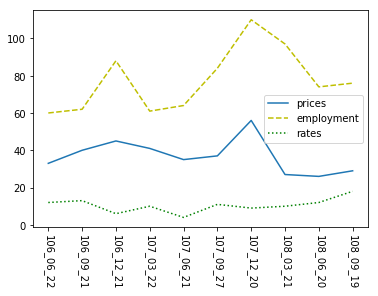

In [79]:
plt.plot(long_name,topicnum(long_topic_0), label = labels[0])

plt.plot(long_name,topicnum(long_topic_1), label = labels[1], c='y', linestyle = 'dashed')

plt.plot(long_name,topicnum(long_topic_2), label = labels[2], c='g', linestyle = 'dotted')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_num.png',dpi = 100,bbox_inches = 'tight')
plt.show()


新聞稿各主題數量

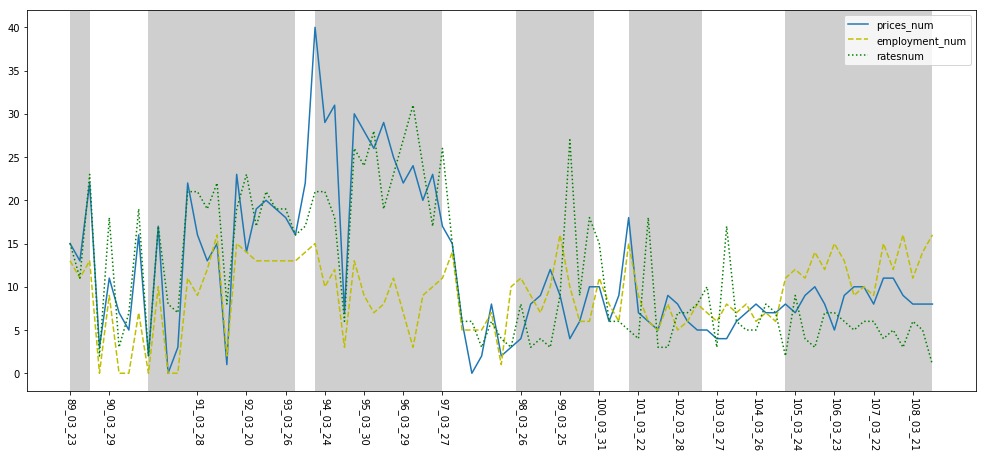

In [80]:
plt.figure(figsize = (17,7))

plt.plot(short_name,topicnum(short_topic_0), label = labels[0]+'_num')


plt.plot(short_name,topicnum(short_topic_1), label = labels[1]+'_num', c='y', linestyle = 'dashed')


plot_cycle()
plt.plot(short_name,topicnum(short_topic_2), label = labels[2]+'num', c='g', linestyle = 'dotted')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_num.png',dpi = 100,bbox_inches = 'tight')
plt.show()

會議記錄正反面數量

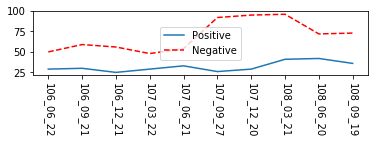

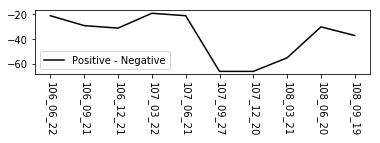

In [81]:
plt.subplot(311)
plt.plot(long_name, long_ponum, label = 'Positive')
plt.plot(long_name, long_nenum, label = 'Negative', c='r',linestyle = 'dashed')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_pone.png',dpi = 100,bbox_inches = 'tight')
plt.show()
plt.subplot(312)
y = [i-j for i,j in zip(long_ponum,long_nenum)]
plt.plot(long_name,y,color = 'k',label = 'Positive - Negative')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_dif.png',dpi = 100,bbox_inches = 'tight')
plt.show()

新聞稿正反面數量

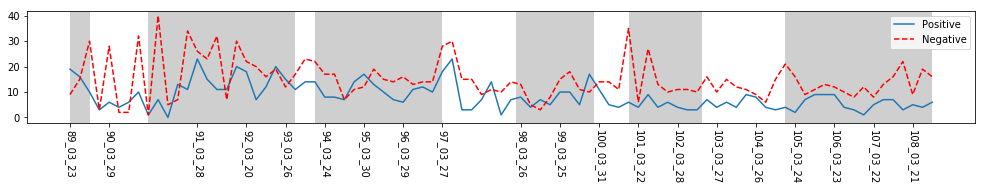

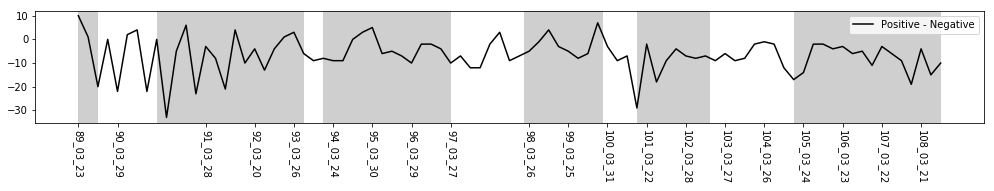

In [82]:
yp = short_ponum
yn = short_nenum
plt.figure(figsize = (17,7))
plt.subplot(311)
plot_cycle()
plt.plot(short_name, yp, label = 'Positive')
plt.plot(short_name, yn, label = 'Negative', c = 'r', linestyle = 'dashed')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_pone.png',dpi = 100,bbox_inches = 'tight')
plt.show()
plt.figure(figsize = (17,7))
plt.subplot(312)
plot_cycle()
y = [i-j for i,j in zip(yp,yn)]
plt.plot(short_name,y,color = 'k',label = 'Positive - Negative')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_dif.png',dpi = 100,bbox_inches = 'tight')
plt.show()

會議記錄區分主題下正反面數量

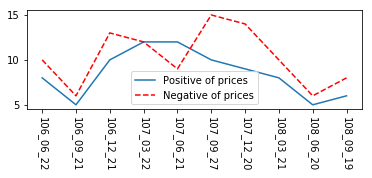

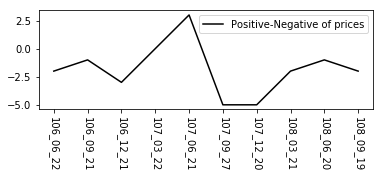

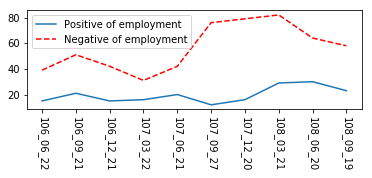

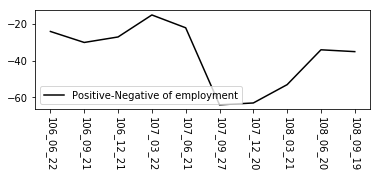

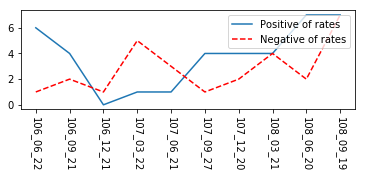

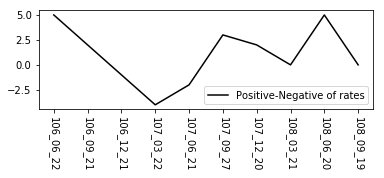

In [84]:
x = long_name

yp = long_topic_0_ponum
yn = long_topic_0_nenum
plt.subplot(211)
plt.plot(x,yp,label = 'Positive of '+labels[0])
plt.plot(x,yn,label = 'Negative of '+labels[0], c='r', linestyle = 'dashed')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_pone_' + labels[0] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()
y = [i-j for i,j in zip(yp,yn)]
plt.subplot(212)
plt.plot(x,y,label = 'Positive-Negative of '+labels[0], c='k')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_dif_' + labels[0] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()



yp = long_topic_1_ponum
yn = long_topic_1_nenum
plt.subplot(211)
plt.plot(x,yp,label = 'Positive of '+labels[1])
plt.plot(x,yn,label = 'Negative of '+labels[1], c='r', linestyle = 'dashed')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_pone_' + labels[1] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()
y = [i-j for i,j in zip(yp,yn)]
plt.subplot(212)
plt.plot(x,y,label = 'Positive-Negative of '+labels[1], c='k')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_dif_' + labels[1] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()



yp = long_topic_2_ponum
yn = long_topic_2_nenum
plt.subplot(211)
plt.plot(x,yp,label = 'Positive of '+labels[2])
plt.plot(x,yn,label = 'Negative of '+labels[2], c='r', linestyle = 'dashed')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_pone_' + labels[2] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()
y = [i-j for i,j in zip(yp,yn)]
plt.subplot(212)
plt.plot(x,y,label = 'Positive-Negative of '+labels[2], c='k')
plt.xticks(rotation = 270)
plt.legend()
plt.savefig('./chart/classic/long_dif_' + labels[2] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()





















新聞稿區分主題下正反面數量

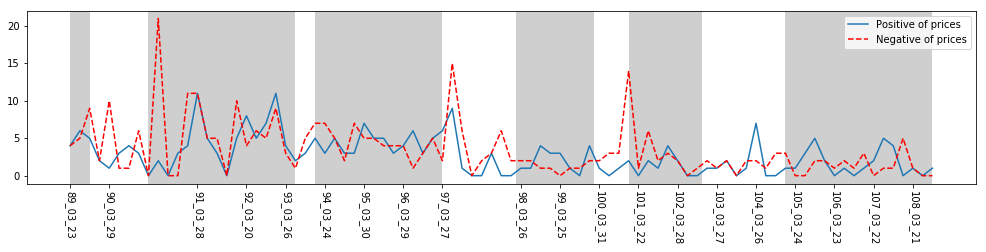

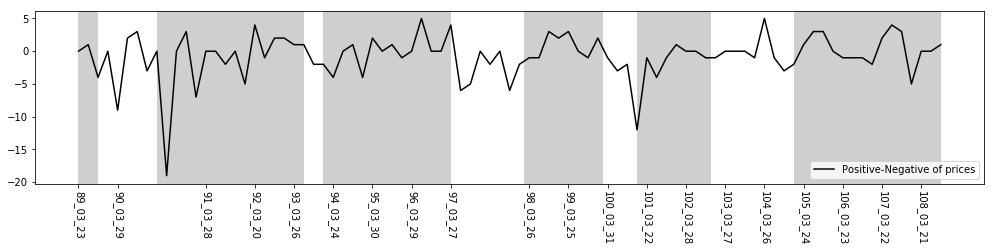

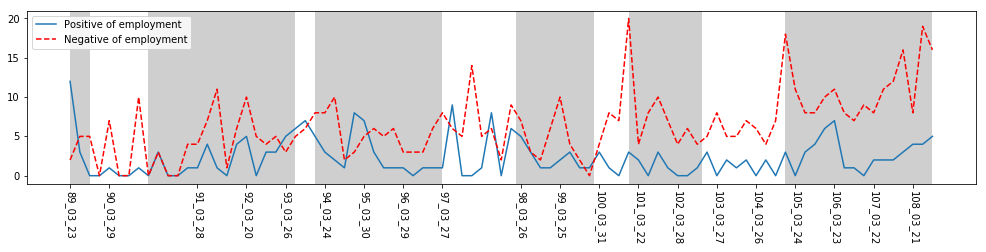

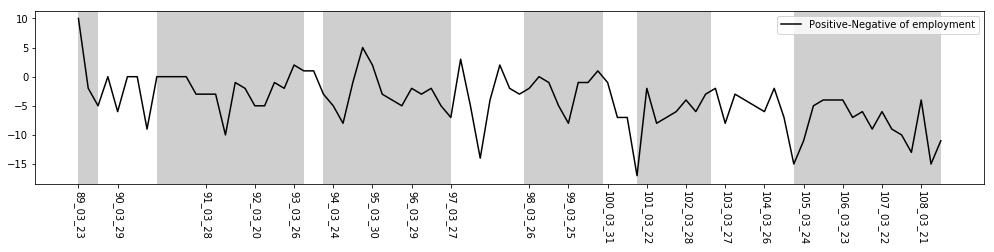

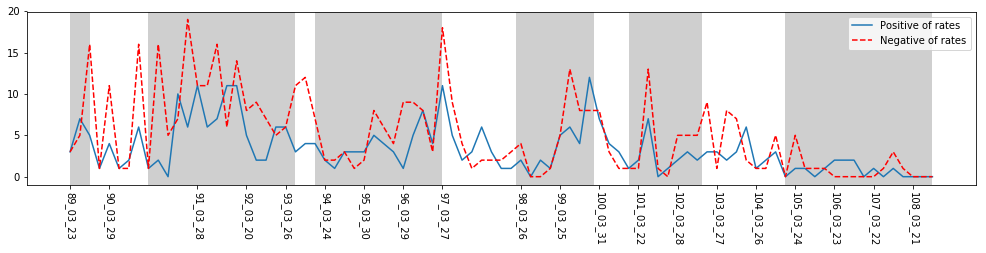

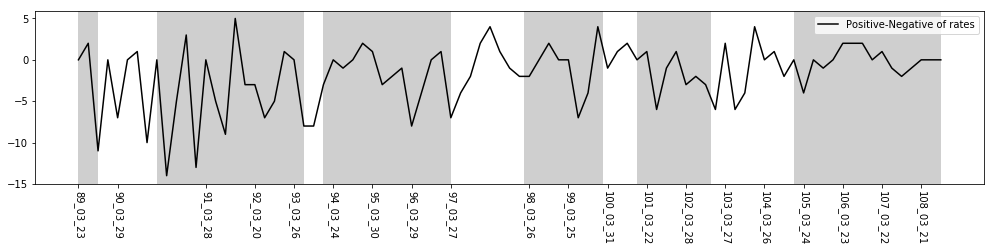

In [85]:
x = short_name
#employment
yp = short_topic_0_ponum
yn = short_topic_0_nenum
plt.figure(figsize = (17,7))
plt.subplot(211)
plot_cycle()
plt.plot(x,yp,label = 'Positive of '+labels[0])
plt.plot(x,yn,label = 'Negative of '+labels[0], c='r', linestyle = 'dashed')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_pone_' + labels[0] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()
y = [i-j for i,j in zip(yp,yn)]
plt.figure(figsize = (17,7))
plt.subplot(212)
plot_cycle()
plt.plot(x,y,label = 'Positive-Negative of '+labels[0], c='k')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_dif_' + labels[0] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()


#prices
yp = short_topic_1_ponum
yn = short_topic_1_nenum
plt.figure(figsize = (17,7))
plt.subplot(211)
plot_cycle()
plt.plot(x,yp,label = 'Positive of '+labels[1])
plt.plot(x,yn,label = 'Negative of '+labels[1], c='r', linestyle = 'dashed')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_pone_' + labels[1] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()
y = [i-j for i,j in zip(yp,yn)]
plt.figure(figsize = (17,7))
plt.subplot(212)
plot_cycle()
plt.plot(x,y,label = 'Positive-Negative of '+labels[1], c='k')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_dif_' + labels[1] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()


#rates
yp = short_topic_2_ponum
yn = short_topic_2_nenum
plt.figure(figsize = (17,7))
plt.subplot(211)
plot_cycle()
plt.plot(x,yp,label = 'Positive of '+labels[2])
plt.plot(x,yn,label = 'Negative of '+labels[2], c='r', linestyle = 'dashed')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_pone_' + labels[2] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()
y = [i-j for i,j in zip(yp,yn)]
plt.figure(figsize = (17,7))
plt.subplot(212)
plot_cycle()
plt.plot(x,y,label = 'Positive-Negative of '+labels[2], c='k')
plt.xticks(short_name_03, rotation = 270)
plt.legend()
plt.savefig('./chart/classic/short_dif_' + labels[2] + '.png',dpi = 100,bbox_inches = 'tight')
plt.show()


In [86]:
def read_index(x):
    path = './index/index2/'
    df = pd.read_csv(path + x + '.csv')
    df['time'] = df['time'].map(lambda x : str(int(x.split('M')[0])-1911) + '_' + x.split('M')[1])
    df['time_T'] = df['time'].map(lambda x : x in [i[:-3] for i in short_name])
    df['time_T_long'] = df['time'].map(lambda x : x in [i[:-3] for i in long_name])
    return df
def get_lag_data(x, tone, lag, long=False):
    if long:
        ind = x.iloc[lag:][x.iloc[lag:]['time_T_long'] == True].index
    else:
        ind = x.iloc[lag:][x.iloc[lag:]['time_T'] == True].index
    new_df = pd.DataFrame()
    tmp = []
    tmp2 = []
    for i in ind:
        tmp.append(x['time'].iloc[i])
        for j in range(lag):
            tmp.append(x['growh_rate'].iloc[i-(lag-1-j)])
        tmp.append(x['growh_rate'].iloc[i+1])  
        tmp2.append(tmp)    
        tmp = []
    tmp = np.array(tmp2)
    new_df['time'] = tmp[:,0]
    for j in range(lag):
        c = 'lag_' + str(lag-j)
        new_df[c] = tmp[:,j+1]
    ll = new_df.shape[0]    
    if len(tone) == len(long_topics):
        for i in range(len(long_topics)):
            new_df[f'tone_{i}'] = tone[i][-ll:]
    else:    
        new_df['tone'] = tone[-ll:]
    new_df['y'] = tmp[:,-1] 
    return new_df
def reg(df, sepa, long='short'):
    if sepa:
        tone = []
        for i in range(len(long_topics)):
            tone.append(names[f'short_topic_{i}_tone'])
        a = get_lag_data(df, tone, 3)
        para_name = ['lag_3','lag_2','lag_1']
        for i in range(len(long_topics)):
            para_name += [f'tone_{i}']
        xx = a[para_name].astype('float64')
        yy = a['y'].astype('float64')
        if long == 'mix':
            for i in range(len(long_topics)):
                xx[f'tone_{i}'] = names[f'mix_topic_{i}_tone'][-xx.shape[0]:]
        if long == 'long':
            tone = []
            for i in range(len(long_topics)):
                tone.append(names[f'long_topic_{i}_tone'])
            a = get_lag_data(df, tone, 3, long=True)
            xx = a[para_name].astype('float64')
            yy = a['y'].astype('float64')
    else:    
        tone = short_tone_index
        a = get_lag_data(df, tone, 3)
        xx = a[['lag_3','lag_2','lag_1','tone']].astype('float64')
        yy = a['y'].astype('float64')
        if long == 'mix':
            xx['tone'] = mix_tone_index[-xx.shape[0]:]
        if long == 'long':
            tone = long_tone_index
            a = get_lag_data(df, tone, 3, long=True)
            xx = a[['lag_3','lag_2','lag_1','tone']].astype('float64')
            yy = a['y'].astype('float64')
    est = sm.OLS(yy, xx).fit()
    return est.summary()

def get_para(x):
    if len(x.tables[1])<6:
        r = x.tables[0][1][3].__str__().replace(' ','')
        b = x.tables[1][-1][1].__str__().replace(' ','')
        t = x.tables[1][-1][3].__str__().replace(' ','')
        p = x.tables[1][4][4].__str__().replace(' ','')
        if float(p) < 0.01:
            t += '***'
        elif float(p) < 0.05:
            t += '**'
        elif float(p) < 0.1:
            t += '*'
        else:
            pass        
        return list((b,t,r))
    else:
        r = x.tables[0][1][3].__str__().replace(' ','')
        b0 = x.tables[1][-3][1].__str__().replace(' ','')
        b1 = x.tables[1][-2][1].__str__().replace(' ','')
        b2 = x.tables[1][-1][1].__str__().replace(' ','')
        t0 = x.tables[1][-3][3].__str__().replace(' ','')
        t1 = x.tables[1][-2][3].__str__().replace(' ','')
        t2 = x.tables[1][-1][3].__str__().replace(' ','')
        p0 = x.tables[1][4][4].__str__().replace(' ','')
        p1 = x.tables[1][5][4].__str__().replace(' ','')
        p2 = x.tables[1][6][4].__str__().replace(' ','')
        t = [t0,t1,t2]
        p = [p0,p1,p2]
        for i in range(len(t)):
            if float(p[i]) < 0.01:
                t[i] += '***'
            elif float(p[i]) < 0.05:
                t[i] += '**'
            elif float(p[i]) < 0.1:
                t[i] += '*'
            else:
                pass
        return list((b0,t[0],b1,t[1],b2,t[2],r))

def out_to_csv(x, columns_name, name):
    x = x.T
    col_name = columns_name
    x.columns = col_name
    x.to_csv('./outputs/' + name + '.csv', encoding = 'big5')
    print(f'saved as {name}.csv')    

In [87]:
import statsmodels.api as sm
out_short = pd.DataFrame()
out_long = pd.DataFrame()
out_mix = pd.DataFrame()

In [127]:
print('新聞稿OLS 工業生產指數')
df = read_index('工業生產指數2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))

print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))

print('==============================================================================')
#out_short['工業'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
#out_long['工業'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
#out_mix['工業'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿OLS 工業生產指數
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.296
Date:                Mon, 16 Mar 2020   Prob (F-statistic):             0.0656
Time:                        14:36:00   Log-Likelihood:                -291.92
No. Observations:                  90   AIC:                             591.8
Df Residuals:                      86   BIC:                             601.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.0784      0.113      

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [128]:
print('新聞稿 領先指標(不含趨勢)')
df = read_index('領先指標2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))
print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))
#out_short['領先'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
#out_long['領先'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
#out_mix['領先'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿 領先指標(不含趨勢)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2288.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           2.00e-86
Time:                        14:36:41   Log-Likelihood:                 75.568
No. Observations:                  90   AIC:                            -143.1
Df Residuals:                      86   BIC:                            -133.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.5984      0.076     

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [129]:
print('新聞稿 同時指標(不含趨勢)')
df = read_index('同時指標2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))
print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))
#out_short['同時'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
#out_long['同時'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
#out_mix['同時'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿 同時指標(不含趨勢)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2401.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           2.60e-87
Time:                        14:37:04   Log-Likelihood:                 51.169
No. Observations:                  90   AIC:                            -94.34
Df Residuals:                      86   BIC:                            -84.34
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.6454      0.085     

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [130]:
print('新聞稿 海關出口')
df = read_index('海關出口2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))
print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))
#out_short['海關'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
#out_long['海關'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
#out_mix['海關'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿 海關出口
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.182
Date:                Mon, 16 Mar 2020   Prob (F-statistic):             0.0804
Time:                        14:37:43   Log-Likelihood:                -243.64
No. Observations:                  71   AIC:                             495.3
Df Residuals:                      67   BIC:                             504.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.0031      0.125      0.024

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [131]:
print('新聞稿 CPI成長率')
df = read_index('CPI成長率2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))
print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))
out_short['CPI'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
out_long['CPI'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
out_mix['CPI'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿 CPI成長率
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6382
Date:                Mon, 16 Mar 2020   Prob (F-statistic):              0.637
Time:                        14:38:00   Log-Likelihood:                -98.353
No. Observations:                  90   AIC:                             204.7
Df Residuals:                      86   BIC:                             214.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.0824      0.113      0.7

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [132]:
print('新聞稿 M1B成長率')
df = read_index('M1b成長率2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))
print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))
out_short['M1B'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
out_long['M1B'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
out_mix['M1B'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿 M1B成長率
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     12.98
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           2.61e-08
Time:                        14:38:15   Log-Likelihood:                -157.14
No. Observations:                  90   AIC:                             322.3
Df Residuals:                      86   BIC:                             332.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.1413      0.115      1.2

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     6.449
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           3.27e-07
Time:                        14:38:15   Log-Likelihood:                -151.79
No. Observations:                  90   AIC:                             323.6
Df Residuals:                      80   BIC:                             348.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.1138      0.114      0.998      0.3

In [133]:
print('新聞稿 WPI成長率')
df = read_index('WPI成長率2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))
print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))
out_short['WPI'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
out_long['WPI'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
out_mix['WPI'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿 WPI成長率
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     29.22
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           2.42e-15
Time:                        14:38:45   Log-Likelihood:                -111.21
No. Observations:                  90   AIC:                             230.4
Df Residuals:                      86   BIC:                             240.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.0169      0.095      0.1

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [134]:
print('新聞稿 貨幣機構放款與投資成長率:')
df = read_index('貨幣機構放款與投資成長率2')
print(reg(df,sepa = False))
print(reg(df, sepa = True))
print('==============================================================================')
print('會議記錄')
print(reg(df, long = 'long', sepa = False))
print(reg(df, long = 'long', sepa = True))
print('==============================================================================')
print('混合')
print(reg(df, long = 'mix', sepa = False))
print(reg(df, long = 'mix', sepa = True))
out_short['放投'] = get_para(reg(df,sepa = False)) + get_para(reg(df,sepa = True))
out_long['放投'] = get_para(reg(df,long='long',sepa = False)) + get_para(reg(df,long='long',sepa = True))
out_mix['放投'] = get_para(reg(df,long='mix',sepa = False)) + get_para(reg(df,long='mix',sepa = True))

新聞稿 貨幣機構放款與投資成長率:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     7.562
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           2.87e-05
Time:                        14:39:27   Log-Likelihood:                -64.766
No. Observations:                  90   AIC:                             137.5
Df Residuals:                      86   BIC:                             147.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_3          0.2859      0.109  

C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\wangyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [96]:
columns_name = ['b','t-stat','AdjR2','b0','t-stat','b1','t-stat','b2','t-stat','AdjR2']
out_to_csv(out_long, columns_name, 'out_long_classic')
out_to_csv(out_short, columns_name, 'out_short_classic')
out_to_csv(out_mix, columns_name, 'out_mix_classic')

saved as out_long_classic.csv
saved as out_short_classic.csv
saved as out_mix_classic.csv
